In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root = '/content/drive/MyDrive/small_ml/'

friends = pd.read_csv(root + 'data_tr.csv')
friends.head()

,u,v,t,h
0,8538,53245,82,9
1,32991,41149,39,4
2,30104,35030,25,4
3,26292,48613,37,1
4,31603,32991,59,9


In [ ]:
print(f'Unique friends u: {len(friends.u.unique())}')

Unique friends u: 9300


In [ ]:
print(f'Unique friends v: {len(friends.v.unique())}')

Unique friends v: 9437


In [ ]:
friends.sort_values(by=['u'])

,u,v,t,h
34355,2,63814,95,3
7000,19,27988,26,2
39044,22,64759,8,6
28219,25,47573,55,5
30746,25,59034,33,4
...,...,...,...,...
37956,83779,84113,58,6
44495,84307,84358,67,1
4866,84324,84435,49,4
23962,84480,84701,6,9


In [ ]:
nodes = pd.concat([friends.u, friends.v]).sort_values().unique()
num_nodes = len(nodes)

In [ ]:
num_nodes

13489

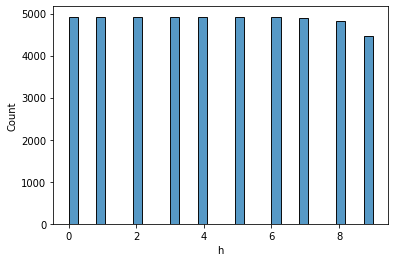

In [ ]:
sns.histplot(friends.h)

In [ ]:
from scipy.sparse import csr_matrix
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from multiprocessing import Pool, cpu_count


class EASE:
    def __init__(self):
        self.user_enc = LabelEncoder()
        self.item_enc = LabelEncoder()

    def _get_users_and_items(self, df):
        users = self.user_enc.fit_transform(df.loc[:, 'user_id'])
        items = self.item_enc.fit_transform(df.loc[:, 'item_id'])
        return users, items

    def fit(self, df, lambda_: float = 0.5, implicit=True):
        """
        df: pandas.DataFrame with columns user_id, item_id and (rating)
        lambda_: l2-regularization term
        implicit: if True, ratings are ignored and taken as 1, else normalized ratings are used
        """
        users, items = self._get_users_and_items(df)
        values = (
            np.ones(df.shape[0])
            if implicit
            else df['rating'].to_numpy() / df['rating'].max()
        )

        X = csr_matrix((values, (users, items)))
        self.X = X

        G = X.T.dot(X).toarray()
        diagIndices = np.diag_indices(G.shape[0])
        G[diagIndices] += lambda_
        P = np.linalg.inv(G)
        B = P / (-np.diag(P))
        B[diagIndices] = 0

        self.B = B
        self.pred = X.dot(B)

    def predict(self, train, users, items, k):
        items = self.item_enc.transform(items)
        dd = train.loc[train.user_id.isin(users)]
        dd['ci'] = self.item_enc.transform(dd.item_id)
        dd['cu'] = self.user_enc.transform(dd.user_id)
        g = dd.groupby('cu')
        with Pool(cpu_count()) as p:
            user_preds = p.starmap(
                self.predict_for_user,
                [(user, group, self.pred[user, :], items, k) for user, group in g],
            )
        df = pd.concat(user_preds)
        df['item_id'] = self.item_enc.inverse_transform(df['item_id'])
        df['user_id'] = self.user_enc.inverse_transform(df['user_id'])
        return df

    @staticmethod
    def predict_for_user(user, group, pred, items, k):
        watched = set(group['ci'])
        candidates = [item for item in items if item not in watched]
        pred = np.take(pred, candidates)
        res = np.argpartition(pred, -k)[-k:]
        r = pd.DataFrame(
            {
                "user_id": [user] * len(res),
                "item_id": np.take(candidates, res),
                "score": np.take(pred, res),
            }
        ).sort_values('score', ascending=False)
        return r

In [ ]:
ease = EASE()

In [ ]:
friends = friends.rename(columns={'u':'user_id', 'v':'item_id', 'h':'rating'}).drop(columns=['t'])
friends_t = friends.copy()
friends_t['user_id'] = friends['item_id']
friends_t['item_id'] = friends['user_id']
all_interactions = pd.concat([friends, friends_t])

In [ ]:
all_interactions.rating.mean()

4.44734514184616

In [ ]:
ease.fit(all_interactions, implicit=False, lambda_=8.0)

In [ ]:
preds = ease.predict(all_interactions, nodes, nodes, k=11)

In [ ]:
preds

,user_id,item_id,score
0,2,28447,0.000000
1,2,28425,0.000000
2,2,28403,0.000000
3,2,28443,0.000000
4,2,28458,0.000000
...,...,...,...
4,84739,38030,0.021487
3,84739,82300,0.020396
1,84739,67271,0.020160
2,84739,72130,0.020124


In [ ]:
ans = []
preds = preds[preds['user_id']!=preds['item_id']]

for user in preds.user_id.unique():
    ans.append(f'{user}: {list(preds[preds["user_id"]==user].item_id)[:10]}'.replace('[', '').replace(']', ''))

In [ ]:
ans

['2: 28447, 28425, 28403, 28443, 28458, 28420, 28375, 28392, 28390, 28379',
 '19: 9492, 15727, 81291, 9203, 84386, 70063, 59967, 83698, 1480, 7528',
 '22: 20958, 2328, 42533, 39834, 49147, 70854, 76418, 80206, 59229, 57010',
 '25: 83040, 3469, 11434, 41531, 1179, 62509, 28694, 76812, 43072, 12842',
 '26: 5317, 28598, 66943, 24719, 47576, 70567, 25974, 51075, 61550, 48326',
 '29: 28458, 28443, 28420, 28446, 28465, 28425, 28379, 28403, 28392, 28390',
 '31: 28447, 28425, 28403, 28443, 28458, 28420, 28375, 28392, 28390, 28379',
 '33: 28447, 28425, 28403, 28443, 28458, 28420, 28375, 28392, 28390, 28379',
 '38: 28447, 28425, 28403, 28443, 28458, 28420, 28375, 28392, 28390, 28379',
 '40: 20791, 28686, 54467, 37181, 49064, 2570, 51628, 11333, 56437, 25917',
 '46: 4610, 32215, 10696, 39750, 61156, 25384, 36440, 71007, 56101, 5998',
 '50: 28447, 28425, 28403, 28443, 28458, 28420, 28375, 28392, 28390, 28379',
 '51: 28458, 28443, 28420, 28446, 28465, 28425, 28379, 28403, 28392, 28390',
 '55: 40294

In [ ]:
with open(root + "submission_ease.txt", "w") as fout:
    print("\n".join(ans), file=fout)